<center>
    <h1>URBASPACE - SIGHT LINES</h1>
    <h2>PLOT Indicators</h2>
    <h3 style = 'color:#FF5733'>Compute sightline PLOT indicators</h3>        
</center>
<hr/>


In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import rtree

from shapely.ops import unary_union
from shapely.geometry import Point,Polygon,MultiPoint,MultiLineString,LineString

# Configuration - Zone

In [2]:
PARAM_insee_layer_name,PARAM_insee_code = 'samples','06'

# Configuration - General parameters

In [3]:
PARAM_default_street_width = 3

PARAM_tan_line_width=300
PARAM_sight_line_width=50
PARAM_sight_line_spacing=3
PARAM_sight_line_junction_size = 0.5
PARAM_sight_line_angle_tolerance = 5

SIGHTLINE_LEFT  = 0
SIGHTLINE_RIGHT = 1
SIGHTLINE_FRONT = 2
SIGHTLINE_BACK = 3


PARAM_sight_line_plot_depth_extension = 300 # meter of extension to compute depth of plot

# DATA - Load road network (from cached geometries)

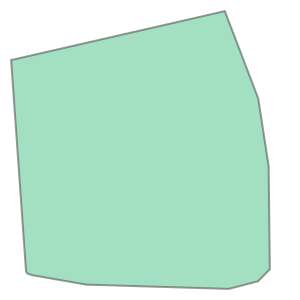

In [4]:
gdf_streets = pd.read_pickle("my_results/method_1/d06_road_network.pickle")

# EXTENDS roads points/nodes to buffer size by computing convex hull of all streets
points = []
for i,res in gdf_streets.iterrows():
    for pt in res.geometry.coords:
        points.append(pt) 
mpt = MultiPoint(points)
hull = mpt.convex_hull

plot_extension_area =  hull.buffer(PARAM_sight_line_width)

display(hull)
del points
del gdf_streets

# DATA - Load Plot (Parcels)
* Add buffer corresponding to possible plots around each roads at signtline width

In [5]:
gdf_parcels = gpd.read_file("data/select/gdf_parcels_select.gpkg")

gdf_parcels['parcel_id']=gdf_parcels.index

display(gdf_parcels)

,contenance,parcel_id,geometry
0,968,0,"POLYGON ((1023777.669 6282894.227, 1023767.444..."
1,1080,1,"POLYGON ((1023750.666 6282866.87, 1023750.286 ..."
2,0,2,"POLYGON ((1023769.081 6282810.204, 1023760.601..."
3,385,3,"POLYGON ((1023753.749 6282915.758, 1023750.272..."
4,318,4,"POLYGON ((1023753.416 6282942.227, 1023753.434..."
...,...,...,...
8261,396,8261,"POLYGON ((1026920.547 6283554.224, 1026941.78 ..."
8262,8551,8262,"POLYGON ((1026951.94 6283652.611, 1026963.317 ..."
8263,8,8263,"POLYGON ((1026853.109 6283609.269, 1026854.947..."
8264,85,8264,"POLYGON ((1026891.582 6283730.209, 1026891.991..."


 # DATA - Load sightlines cache

In [6]:
df_sightlines = pd.read_pickle("my_results/method_1/d06_sightlines_geometries.pickle")


# Drop columns ensuring memory is realsed
columns_to_keep = ['uid',
                   'street_length',
                   'sight_line_points',
                   'left_OS_count',
                   'left_SEQ_OS_endpoints',
                   'right_OS_count',
                   'right_SEQ_OS_endpoints']
all_columns=list(df_sightlines)
for col in all_columns:
    if not col in columns_to_keep:
        del df_sightlines[col]

display(f'{len(df_sightlines)} roads')
display(df_sightlines.head(100).transpose())

'2167 roads'

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
sight_line_points,"[(1025242.6754464795, 6281649.269788036), (102...","[(1025177.5965266357, 6281540.609405861), (102...","[(1025425.00475656, 6281582.356152114), (10254...","[(1025475.9339181399, 6281507.3043860495), (10...","[(1025215.6132290525, 6281671.216872584), (102...","[(1025181.9967533152, 6281773.400010541), (102...","[(1025461.8107783925, 6281661.753401003), (102...","[(1025476.4959228921, 6281507.863721936), (102...",[],"[(1025411.3984076392, 6281500.839872611), (102...",...,"[(1024495.5728365858, 6282187.481000958), (102...","[(1024508.892675253, 6282195.885270717), (1024...","[(1024833.0551529635, 6281483.335947163), (102...","[(1024613.8327950775, 6281634.928786128), (102...","[(1024586.8998194411, 6281720.913436007), (102...","[(1024853.82760041, 6281974.794730532), (10248...",[],"[(1024529.0400259448, 6281507.101604651), (102...","[(1025348.3476544137, 6282731.602276123), (102...","[(1025665.801977127, 6282876.71050979), (10256..."
left_OS_count,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, ...","[2, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
right_OS_count,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...","[19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 4, 4, 5, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,"[1, 1, 1, 3, 4, 4, 2, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
left_SEQ_OS_endpoints,"[(1025275.696642899, 6281686.8144359505), (102...","[(1025226.6559404726, 6281550.26206943), (1025...","[(1025379.3895451528, 6281602.831808106), (102...","[(1025525.4953131748, 6281500.69620005), (1025...","[(1025183.9259706901, 6281632.539777845), (102...","[(1025231.9956992079, 6281773.075342062), (102...","[(1025416.4706781327, 6281682.831240276), (102...","[(1025470.1237293637, 6281557.456011152), (102...",[],"[(1025407.4111465445, 6281550.680636539), (102...",...,"[(1024537.4727408248, 6282214.764659524), (102...","[(1024500.3656035725, 6282245.1527960105), (10...","[(1024789.4604367055, 6281458.851243482), (102...","[(1024660.954182351, 6281618.208293868), (1024...","[(1024585.5562188029, 6281770.89538012), (1024...","[(1024804.3545472029, 6281967.554771529), (102...",[],"[(1024578.8795608284, 6281511.104199132), (102...","[(1025398.1200420252, 6282736.367717493), (102...","[(1025714.7509981154, 6282886.908222488), (102..."
right_SEQ_OS_endpoints,"[(1025209.65425006, 6281611.725140122), (10252...","[(1025128.5371127988, 6281530.956742292), (102...","[(1025470.6199679672, 6281561.880496123), (102...","[(1025426.372523105, 6281513.912572049), (1025...","[(1025247.3004874149, 6281709.893967323), (102...","[(1025

# Spatial index (parcels)

In [7]:
class RtreeIndex:
    gdf = None
    rtree_index = None
    geom_rtree_list = None
    uid_rtree_list = None
    name = None
    verbose_function = None

    def __init__(self, name, gdf, verbose_function=None):
        self.name = name
        self.gdf = gdf
        self.verbose_function=verbose_function
        rtree_index = rtree.index.Index()
        # build spatial index
        self.log("rtree creation...")
        geom_rtree_list = []
        uid_rtree_list = []
        rtree_id = 0
        for uid, res in gdf.iterrows():
            geom = res.geometry
            geom_rtree_list.append(geom)
            uid_rtree_list.append(uid)
            rtree_index.insert(rtree_id, geom.bounds)
            rtree_id += 1
        self.log("rtree built.")
        self.rtree_index = rtree_index
        self.geom_rtree_list = geom_rtree_list
        self.uid_rtree_list = uid_rtree_list

    def extract_ids(self, intersecting_geom):
        iterator = self.rtree_index.intersection(intersecting_geom.bounds)
        result = []
        for rtree_position in iterator:
            geom = self.geom_rtree_list[rtree_position]
            if not geom.is_valid:
                geom = geom.buffer(-0.001)
            isect = intersecting_geom.intersection(geom)
            if not isect.is_empty:
                result.append(rtree_position)
        return result

    def select(self, ids):
        return self.gdf.iloc[ids]

    def log(self, message):
        if self.verbose_function is not None:
            self.verbose_function(f'RTREE[{self.name}]: {message}')

In [8]:
rtree_parcels = RtreeIndex("parcels", gdf_parcels)

# per street sighlines indicators

In [9]:
def extend_line_end(line, distance):
    coords = line.coords
    nbp = len(coords)

    len_ext = distance + 1  # eps

    # extend line start point
    Ax, Ay = coords[0]
    Bx, By = coords[1]

    # extend line end point
    Ax, Ay = coords[nbp - 1]
    Bx, By = coords[nbp - 2]
    lenAB = math.sqrt((Ax - Bx) ** 2 + (Ay - By) ** 2);
    xe = Ax + (Ax - Bx) / lenAB * len_ext;
    ye = Ay + (Ay - By) / lenAB * len_ext;

    # return LineString([[xs,ys]]+coords[1:nbp]+[[xe,ye]])
    return LineString(coords[0:nbp - 1] + [[xe, ye]])

In [10]:
def compute_sigthlines_plot_indicators_one_side(sight_line_points,
                                                OS_count,
                                                SEQ_OS_endpoint):
   
    
        
    
    parcel_SB_count=[]
    parcel_SEQ_SB_ids=[]
    parcel_SEQ_SB=[]
    parcel_SEQ_SB_depth=[]
    
    
    N = len(sight_line_points)
    if N==0:         
        parcel_SB_count=[0 for sight_point in sight_line_points]
        return [parcel_SB_count,
                parcel_SEQ_SB_ids,
                parcel_SEQ_SB,
                parcel_SEQ_SB_depth]
           
    idx_end_point=0
    
             
    for sight_point,os_count in zip(sight_line_points,
                                    OS_count):
        n_sightlines_touching = 0
        for i in range(os_count):
            sight_line_geom = LineString([sight_point,SEQ_OS_endpoint[idx_end_point]])
            s_pt1 = Point(sight_line_geom.coords[0])
            
            gdf_items = gdf_parcels.iloc[rtree_parcels.extract_ids(sight_line_geom)]
            
            match_distance = PARAM_sight_line_width # set max distance if no polygon intersect
            match_id = None
            match_geom = None
            
            
            for i,res in gdf_items.iterrows():   
                # building geom
                geom = res.geometry
                geom = geom if isinstance(geom,Polygon) else geom.geoms[0] 
                contour = LineString(geom.exterior.coords)        
                isect = sight_line_geom.intersection(contour)    
                if not isect.is_empty:        
                    if isinstance(isect,Point):
                        isect=[isect]
                    elif isinstance(isect,LineString):
                        isect = [Point(coord) for coord in isect.coords]
                    elif isinstance(isect,MultiPoint):
                        isect = [pt for pt in isect.geoms]
                        
                    for pt_sec in isect:
                        dist = s_pt1.distance(pt_sec)
                        if dist < match_distance:
                            match_distance = dist                          
                            match_id = res.parcel_id
                            match_geom = geom
            
            #---------------
            # result in intersightline
            if match_id is not None:
                n_sightlines_touching+=1
                parcel_SEQ_SB_ids.append(match_id)
                parcel_SEQ_SB.append(match_distance)
                # compute depth of plot intersect sighline etendue 
                try:
                    if not match_geom.is_valid:
                        match_geom=match_geom.buffer(0)
                    isec = match_geom.intersection(extend_line_end(sight_line_geom,PARAM_sight_line_plot_depth_extension))                                
                    if (not isinstance(isec,LineString)) and (not isinstance(isec,MultiLineString)):
                        display( (not isinstance(isec,LineString)) , (not isinstance(isec,MultiLineString)))
                        raise Exception('Not allowed: intersection is not of type Line')
                    parcel_SEQ_SB_depth.append(isec.length)
                except Exception as e:
                    display(match_geom)
                    display(sight_line_geom)
                    display(f'Parcel[{match_id}] validity: {match_geom.is_valid}')
                    display(sight_line_geom.is_valid)
                    raise e
                            
            #------- iterate
            idx_end_point+=1
        
        parcel_SB_count.append(n_sightlines_touching)

    
    
    
    
    return [parcel_SB_count,
            parcel_SEQ_SB_ids,
            parcel_SEQ_SB,
            parcel_SEQ_SB_depth]

# DEBUG/DISPLAY

In [11]:
def DEBUG_plot_road(uid):
    row = df_sightlines.loc[uid]
    sight_line_points=row.sight_line_points
    left_OS_count=row.left_OS_count
    left_SEQ_OS_endpoints=row.left_SEQ_OS_endpoints
    right_OS_count=row.right_OS_count
    right_SEQ_OS_endpoints=row.right_SEQ_OS_endpoints
    
    values=[]
    
    idx_left_end_point=0
    idx_right_end_point=0
     
    for point_id, start_point,left_count,right_count in zip(range(len(sight_line_points)),
                                                            sight_line_points,
                                                            left_OS_count,
                                                            right_OS_count):
        for i in range(left_count):
            values.append([LineString([start_point,left_SEQ_OS_endpoints[idx_left_end_point]]),
                           point_id,
                           SIGHTLINE_LEFT])
            idx_left_end_point+=1
        for i in range(right_count):
            values.append([LineString([start_point,right_SEQ_OS_endpoints[idx_right_end_point]]),
                           point_id,
                           SIGHTLINE_RIGHT])
            idx_right_end_point+=1
                  
    gdf_sight_lines = gpd.GeoDataFrame(values,columns=['geometry','point_id','sight_type'])
 
    geom_bounds = unary_union(gdf_sight_lines.geometry).buffer(5).exterior
    
    gdf_items = gdf_parcels.iloc[rtree_parcels.extract_ids(geom_bounds)]
    
    sight_points = [Point(line.coords[0]) for line in gdf_sight_lines.geometry.values]
    
    
    # algo 
    side_values = compute_sigthlines_plot_indicators_one_side(
        row.sight_line_points,
        row.left_OS_count,
        row.left_SEQ_OS_endpoints)
    sight_line_values.append(side_values)
    
    
    
    
    fig,ax = plt.subplots(1,1,figsize=(20,20))
    gdf_items.plot(ax=ax,color='lightgray',edgecolor='gray')#column='category', categorical=True,cmap='Pastel2',legend=True,label='category')
    gpd.GeoDataFrame(sight_points,columns=['geometry']).plot(color='black',markersize=50,ax=ax)
    side_color_table=['green','lightblue'] 
    for side_type,side_color in zip([SIGHTLINE_LEFT,SIGHTLINE_RIGHT],side_color_table):
        gdf_side_main = gdf_sight_lines[gdf_sight_lines.sight_type==side_type].drop_duplicates(subset=['point_id'],keep='first')        
        gdf_side_snail = gdf_sight_lines[gdf_sight_lines.sight_type==side_type].drop(gdf_side_main.index)
    
        gdf_side_main.plot(color=side_color,linewidth=1,  ax=ax) if len(gdf_side_main)>0 else None
        gdf_side_snail.plot(color=side_color,linewidth=1,  ax=ax) if len(gdf_side_snail)>0 else None
    
    plt.show()
    
    
    display(gdf_sight_lines)
    
#DEBUG_plot_road(74333382)  # 06
#DEBUG_plot_road(74247563)  # BUG geom 06

# MAIN PROCESS

In [12]:
def extend_line_end(line, distance):
    coords = line.coords
    nbp = len(coords)

    len_ext = distance + 1  # eps

    # extend line start point
    Ax, Ay = coords[0]
    Bx, By = coords[1]

    # extend line end point
    Ax, Ay = coords[nbp - 1]
    Bx, By = coords[nbp - 2]
    lenAB = math.sqrt((Ax - Bx) ** 2 + (Ay - By) ** 2);
    xe = Ax + (Ax - Bx) / lenAB * len_ext;
    ye = Ay + (Ay - By) / lenAB * len_ext;

    # return LineString([[xs,ys]]+coords[1:nbp]+[[xe,ye]])
    return LineString(coords[0:nbp - 1] + [[xe, ye]])

In [13]:
values=[]

for uid,row in df_sightlines.iterrows():   
    
    sight_line_values=[uid]
        
    side_values = compute_sigthlines_plot_indicators_one_side(
        row.sight_line_points,
        row.left_OS_count,
        row.left_SEQ_OS_endpoints)
    sight_line_values += side_values
    
    side_values = compute_sigthlines_plot_indicators_one_side(
        row.sight_line_points,
        row.right_OS_count,
        row.right_SEQ_OS_endpoints)
    sight_line_values += side_values
    
    values.append(sight_line_values)

In [14]:
df_results = pd.DataFrame(values,columns=['uid',
                                  'left_parcel_SB_count',
                                  'left_parcel_SEQ_SB_ids',
                                  'left_parcel_SEQ_SB',
                                  'left_parcel_SEQ_SB_depth',
                                  'right_parcel_SB_count',
                                  'right_parcel_SEQ_SB_ids',
                                  'right_parcel_SEQ_SB',
                                  'right_parcel_SEQ_SB_depth'])
df_results= df_results.set_index('uid',drop=False)
display(f'{len(df_results)} items')
display(df_results.head())

'2167 items'

,uid,left_parcel_SB_count,left_parcel_SEQ_SB_ids,left_parcel_SEQ_SB,left_parcel_SEQ_SB_depth,right_parcel_SB_count,right_parcel_SEQ_SB_ids,right_parcel_SEQ_SB,right_parcel_SEQ_SB_depth
uid,,,,,,,,,
0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[3476, 3476, 3479, 3479, 3479, 3479, 3479, 347...","[36.82972315729576, 7.648974870591288, 4.05030...","[40.1901116414097, 69.48728118341555, 4.050306...","[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...","[4781, 3479, 3479, 3479, 3479, 3479, 3479, 347...","[40.44162126884802, 4.335545434370225, 3.82396...","[4.532114556130251, 1.347395763460938, 1.49086..."
1,1,"[18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","[4747, 4747, 4747, 4747, 4747, 4747, 4747, 474...","[3.563424630804314, 3.615279369690467, 3.69721...","[58.19375785732472, 58.5234078979305, 59.26279...","[13, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[4747, 4746, 4746, 4746, 4746, 4746, 4746, 474...","[3.539593912018871, 49.72370548945467, 49.3770...","[58.30856935628116, 49.72370548945467, 49.3770..."
2,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4803, 4803, 4803, 4803, 4803, 4803, 4803, 480...","[5.5501990398511385, 5.48670807912527, 5.42321...","[33.75701962096642, 29.291344672125803, 24.825...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[3277, 3277, 3277, 3277, 3277, 3277, 3277, 327...","[6.151006162700524, 5.985026160057169, 6.00010...","[24.61413557088359, 29.676763338720654, 34.558..."
3,3,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, ...","[3257, 3257, 3257, 3257, 3270, 3270, 3270, 326...","[0.45560255389895754, 0.3584285155131019, 0.21...","[0.45560255389895754, 0.3584285155131019, 0.21...","[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 0, 0, 0, ...","[3257, 3257, 3257, 3257, 3257, 3257, 3270, 325...","[5.107955288289861, 16.135868016368878, 21.964...","[5.107955288289861, 16.135868016368878, 21.964..."
4,4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4758, 4776, 4776, 4776, 4759, 4759, 4763, 476...","[31.70922617648965, 5.1003169003380755, 5.1697...","[0.8298260155856593, 8.523985026262514, 8.6828...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4792, 4792, 3482, 3482, 3482, 3482, 3481, 348...","[2.6737744068545113, 2.6591399435435608, 2.652...","[11.764083333414185, 12.27320472453308, 8.3700..."


# DEBUG

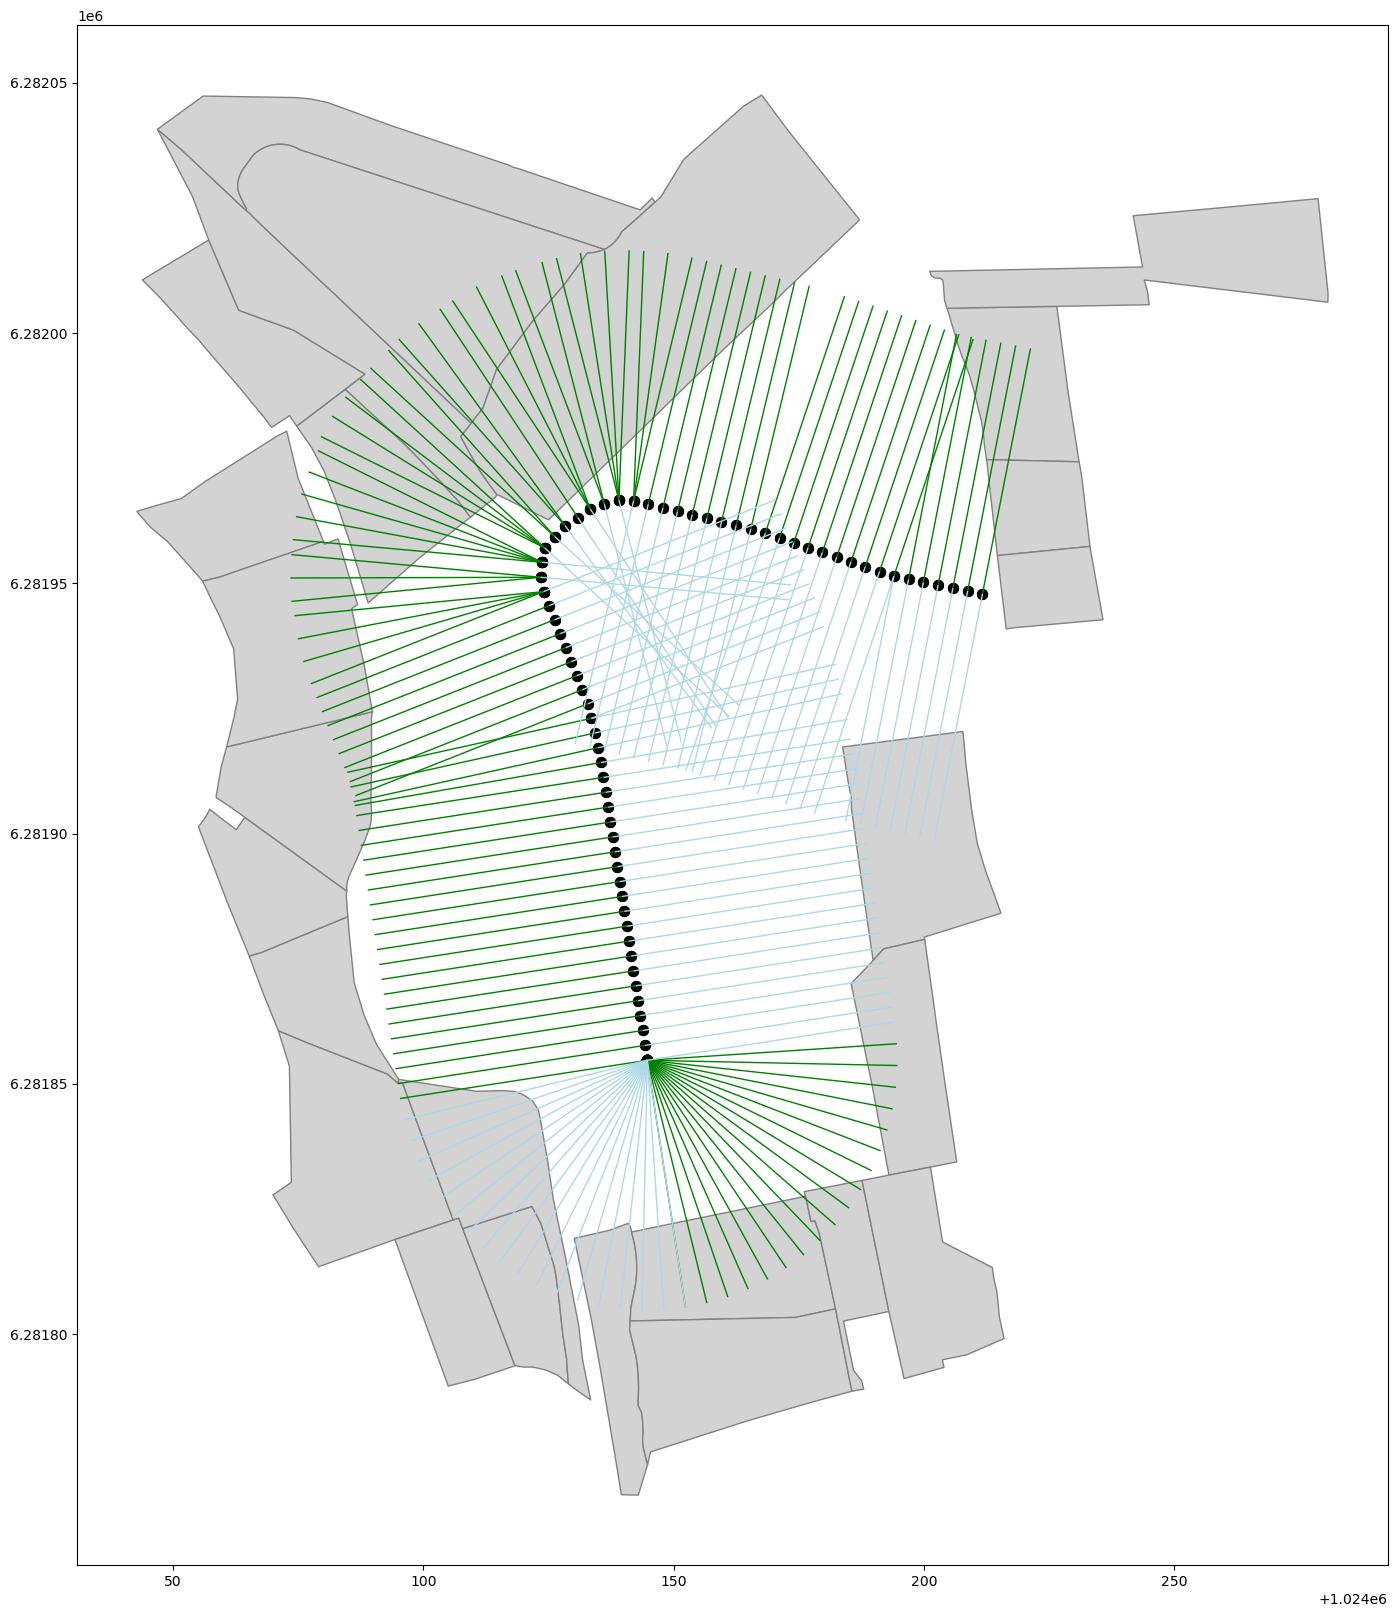

,geometry,point_id,sight_type
0,"LINESTRING (1024144.724 6281854.694, 1024095.3...",0,0
1,"LINESTRING (1024144.724 6281854.694, 1024194.6...",0,0
2,"LINESTRING (1024144.724 6281854.694, 1024194.7...",0,0
3,"LINESTRING (1024144.724 6281854.694, 1024194.4...",0,0
4,"LINESTRING (1024144.724 6281854.694, 1024193.7...",0,0
...,...,...,...
189,"LINESTRING (1024205.8 6281949.051, 1024196.205...",64,1
190,"LINESTRING (1024208.754 6281948.474, 1024218.3...",65,0
191,"LINESTRING (1024208.754 6281948.474, 1024199.1...",65,1
192,"LINESTRING (1024211.709 6281947.896, 1024221.3...",66,0


In [15]:
DEBUG_plot_road(2008)

# Join additionnal street indicators 
Needed to compute street level plot one without reloding all sightline pickle

In [16]:
df_results = df_results.join(df_sightlines[['street_length']])
df_results.head()

,uid,left_parcel_SB_count,left_parcel_SEQ_SB_ids,left_parcel_SEQ_SB,left_parcel_SEQ_SB_depth,right_parcel_SB_count,right_parcel_SEQ_SB_ids,right_parcel_SEQ_SB,right_parcel_SEQ_SB_depth,street_length
uid,,,,,,,,,,
0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[3476, 3476, 3479, 3479, 3479, 3479, 3479, 347...","[36.82972315729576, 7.648974870591288, 4.05030...","[40.1901116414097, 69.48728118341555, 4.050306...","[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...","[4781, 3479, 3479, 3479, 3479, 3479, 3479, 347...","[40.44162126884802, 4.335545434370225, 3.82396...","[4.532114556130251, 1.347395763460938, 1.49086...",84.307926
1,1,"[18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","[4747, 4747, 4747, 4747, 4747, 4747, 4747, 474...","[3.563424630804314, 3.615279369690467, 3.69721...","[58.19375785732472, 58.5234078979305, 59.26279...","[13, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[4747, 4746, 4746, 4746, 4746, 4746, 4746, 474...","[3.539593912018871, 49.72370548945467, 49.3770...","[58.30856935628116, 49.72370548945467, 49.3770...",97.823270
2,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4803, 4803, 4803, 4803, 4803, 4803, 4803, 480...","[5.5501990398511385, 5.48670807912527, 5.42321...","[33.75701962096642, 29.291344672125803, 24.825...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[3277, 3277, 3277, 3277, 3277, 3277, 3277, 327...","[6.151006162700524, 5.985026160057169, 6.00010...","[24.61413557088359, 29.676763338720654, 34.558...",43.954636
3,3,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, ...","[3257, 3257, 3257, 3257, 3270, 3270, 3270, 326...","[0.45560255389895754, 0.3584285155131019, 0.21...","[0.45560255389895754, 0.3584285155131019, 0.21...","[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 0, 0, 0, ...","[3257, 3257, 3257, 3257, 3257, 3257, 3270, 325...","[5.107955288289861, 16.135868016368878, 21.964...","[5.107955288289861, 16.135868016368878, 21.964...",102.610135
4,4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4758, 4776, 4776, 4776, 4759, 4759, 4763, 476...","[31.70922617648965, 5.1003169003380755, 5.1697...","[0.8298260155856593, 8.523985026262514, 8.6828...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4792, 4792, 3482, 3482, 3482, 3482, 3481, 348...","[2.6737744068545113, 2.6591399435435608, 2.652...","[11.764083333414185, 12.27320472453308, 8.3700...",37.630051


# BACKUP sightlines plot values as pickle 

In [17]:
df_results.to_pickle('my_results/method_2/d06_sightlines_parcels_dataframe.pickle')

# BACKUP plots items (fetched for this run) as pickle 

In [18]:
plot_extension_area = gpd.GeoDataFrame(geometry=[plot_extension_area])

plot_extension_area.to_pickle('my_results/method_2/d06_sightlines_extension_area_for_parcels_geometry.pickle')